## imports

In [1]:
import numpy as np
import numpy.linalg as mat
import scipy as sp
import scipy.linalg as smat

# from json import JSONDecodeError
import simplejson

# import cvxpy as cp
import osmnx as ox
import networkx as nx
import geopandas as gpd
import pandas as pd
import peartree as pt #turns GTFS feed into a graph
import folium

import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point

from matplotlib.patches import FancyArrow
from itertools import product 
from random import sample
from shapely.geometry import Polygon, Point
import shapely as shp
import plotly.express as px

import alphashape
import matplotlib.pyplot as plt
from descartes import PolygonPatch
import time

# from gtfs_functions import Feed #, map_gdf
import gtfs_functions as gtfs

import pickle

In [2]:
%load_ext autoreload
%autoreload 2
from multimodal_functions import * 

In [3]:
# TERMINAL 1:
# export SERVER='carta-cav'
# ssh -L 8080:localhost:8080 "$SERVER"

# TERMINAL 2:
# export SERVER='carta-cav'
# ssh -L 26025:localhost:26025 "$SERVER"


# LOAD WORLD0

In [4]:
reload_base = True;
#filename = 'data/data1176.obj'
# filename = 'data/data1073.obj';
filename = 'runs/data2524.obj';
# filename = 'data/data353.obj'
# filename = 'data/data103.obj'

if reload_base:
    file = open(filename, 'rb')
    DATA = pickle.load(file)
    DATA = pd.read_pickle(filename)
    file.close()
    
reread_data = True;
if reread_data:
    WORLD0 = DATA['WORLD'];
    NDF = DATA['NDF']
    NODES = DATA['NODES']
    BUS_STOP_NODES = DATA['BUS_STOP_NODES']

In [5]:
# center_point = (-85.3094,35.0458)
# bnds = generate_bnds(center_point)

In [6]:
# print(bnds)

# -----------------------ONLY IF RECOMPUTE DATA ---------------------------
# -----------------------ONLY IF RECOMPUTE DATA ---------------------------

# LOADING GRAPH/NETWORK DATA (takes 30 secs...)

In [7]:
szz = 1.; radius = szz*5000;
start = 8*60*60; end = 9*60*60;
time_window = [start,end]

center_point = (-85.3094,35.0458)
bnds = generate_bnds(center_point)
OUT = SETUP_GRAPHS_CHATTANOOGA(center_point,radius,time_window,bnds = bnds);
GRAPHS = OUT['GRAPHS']; RGRAPHS = OUT['RGRAPHS']; feed = OUT['feed']

INFO:root:Reading "stops.txt".
INFO:root:Reading "stop_times.txt".
INFO:root:get trips in stop_times
INFO:root:accessing trips
INFO:root:Reading "routes.txt".
INFO:root:Reading "trips.txt".
INFO:root:Reading "calendar.txt".
INFO:root:Reading "calendar_dates.txt".
INFO:root:The busiest date/s of this feed or your selected date range is/are:  ['2020-12-25', '2021-01-01', '2020-11-26', '2020-09-07'] with 1230 trips.
INFO:root:In that more than one busiest date was found, the first one will be considered.
INFO:root:In this case is 2020-12-25.
INFO:root:Reading "stop_times.txt".
INFO:root:_trips is defined in stop_times


loading feed...
constructing transit graph from feed...


INFO:root:computing patterns
INFO:root:Reading "shapes.txt".
INFO:root:segments_df: 2113, geometry: 2113


loading drive graph...
loading walk graph...
composing graphs...
computing reverse graphs...
...reversing drive graph...
...reversing walk graph...
...reversing transit graph...
...reversing ondemand graph...
...reversing gtfs graph...
...reversing all graph...
connecting close bus stops...
Original num of edges:  1441
Final num of edges:  2537


# ... plotting...(takes a few secs...)

CPU times: user 1.57 s, sys: 427 ms, total: 2 s
Wall time: 1.01 s


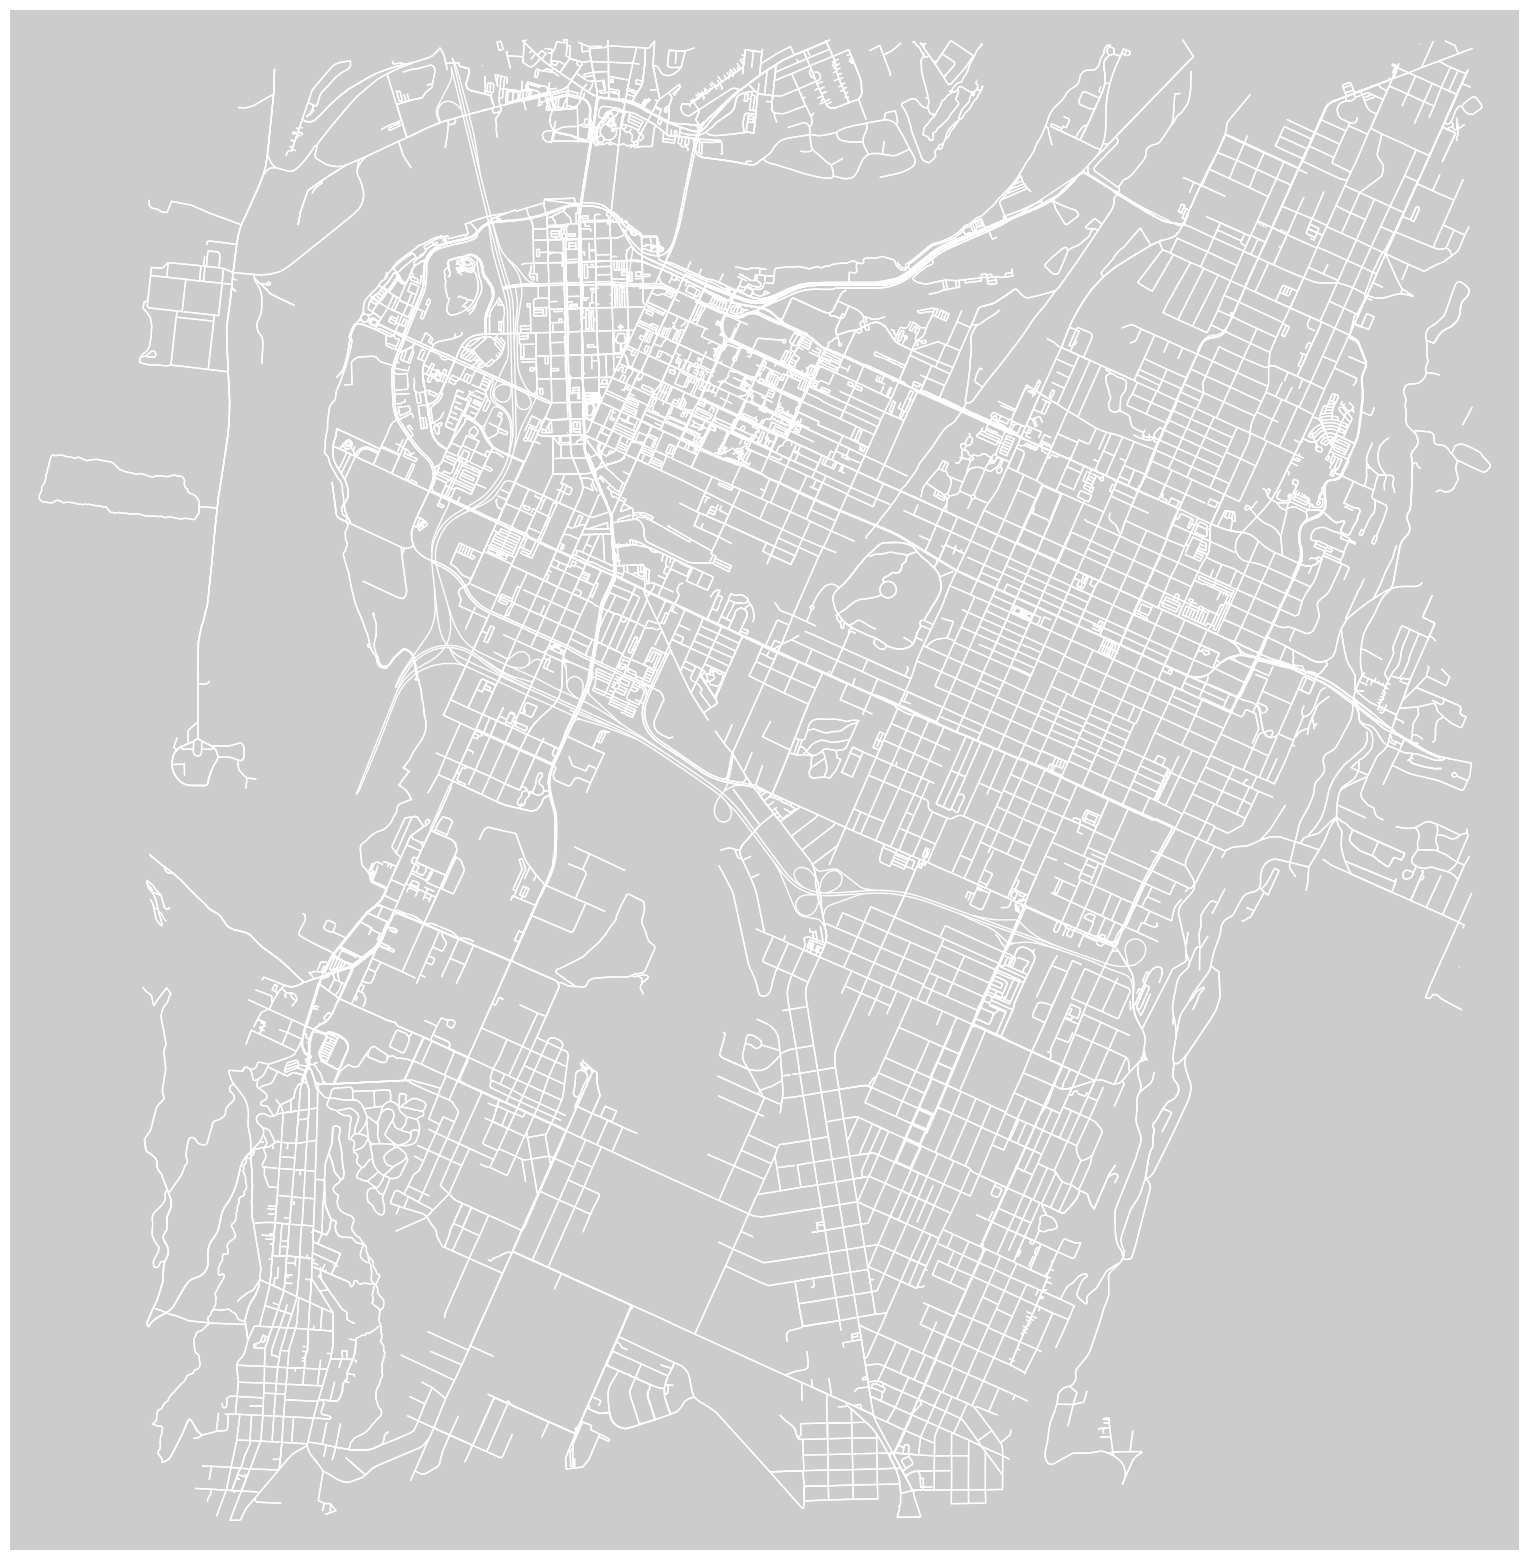

In [8]:
#graph_bus = load_feed_as_graph(feed);
mode = 'all';
bgcolor = [0.8,0.8,0.8,1];
# %time fig, ax = ox.plot_graph(GRAPHS['drive'],bgcolor=bgcolor,node_size=1,figsize=(20,20),edge_color = [1,1,1],show=False,); #file_format='svg')
%time fig, ax = ox.plot_graph(GRAPHS[mode],bgcolor=bgcolor,node_size=1,figsize=(20,20),edge_color = [1,1,1],show=False,); #file_format='svg')

# LOADING POPULATION DATA (takes 1 min...)

Using the default year of 2021
Using FIPS code '47' for input 'TN'
Using FIPS code '065' for input 'Hamilton'
279
1000
2000
3000
total pop is 1214.0 out of 4411.0
number of agents:  431
431
0
starting delivery1 sources...
starting delivery2 sources...
time to create nodes...:  5.7220458984375e-05
time to setup origins & dests:  0.8111670017242432


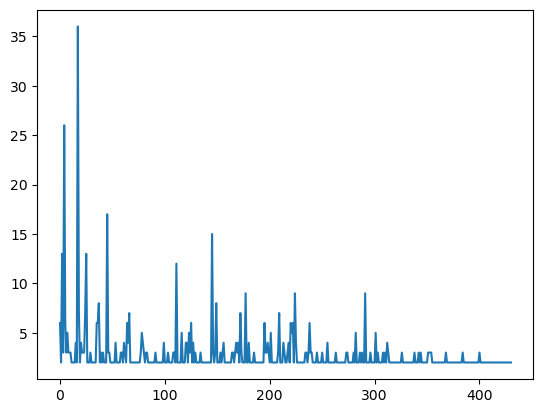

In [9]:

params = {'pop_cutoff':1}
params['SEG_TYPES'] = generate_segtypes('reg6') # reg1,reg2,bg


cent_pt = np.array(center_point)
dest_shift = np.array([0.001,-0.000]);
orig_shift = np.array([0.022,-0.04]);
orig_shift2 = np.array([-0.015,-0.042]);





thd = 0.3; tho = -0.0; tho2 = -0.0;
Rd = np.array([[np.cos(thd),-np.sin(thd)],[np.sin(thd),np.cos(thd)]]);
Ro = np.array([[np.cos(tho),-np.sin(tho)],[np.sin(tho),np.cos(tho)]]);
Ro2 = np.array([[np.cos(tho2),-np.sin(tho2)],[np.sin(tho2),np.cos(tho2)]]);
COVd  = np.diag([0.00002,0.00002]);
COVo  = np.diag([0.00002,0.00008]);
COVo2 = np.diag([0.00002,0.00008]);
# COVd  = np.diag([0.000002,0.000002]);
# COVo  = np.diag([0.000002,0.000002]);
# COVo2 = np.diag([0.000002,0.000002]);
COVd = Rd@COVd@Rd.T
COVo = Ro@COVo@Ro.T
COVo2 = Ro2@COVo2@Ro2.T


params['OD_version'] = 'gauss';
params['gauss_stats'] = [{'num':10,'pop':10,'dests':{'mean':cent_pt+dest_shift,'cov':COVd},
                         'origs':{'mean':cent_pt+orig_shift,'cov':COVo}},
                         {'num':10,'pop':10,'dests':{'mean':cent_pt+dest_shift,'cov':COVd},
                         'origs':{'mean':cent_pt+orig_shift2,'cov':COVo2}}]

params['num_deliveries'] = {'delivery1':20,'delivery2':20}

params['eps_filterODs'] = 0.001
cutoff_bnds = bnds;
# cutoff_bnds = [];
OUT = SETUP_POPULATIONS_CHATTANOOGA(GRAPHS,cutoff_bnds = cutoff_bnds, params=params);
PRE = OUT['PRE'];
NODES = OUT['NODES']; LOCS = OUT['LOCS']; SIZES = OUT['SIZES']; 
VEHS = OUT['VEHS']

In [10]:
print(PRE['person0'])

{'orig_loc': array([-85.29039796,  34.98398373]), 'dest_loc': array([-85.31145309,  35.04534162]), 'take_car': 1.0, 'take_transit': 1.0, 'take_ondemand': 1.0, 'take_walk': 1.0, 'home_node': 202687339, 'work_node': 202605864, 'pop': 10.0, 'seg_types': [('ondemand',), ('walk', 'gtfs', 'walk'), ('walk', 'gtfs', 'ondemand'), ('ondemand', 'gtfs', 'walk'), ('ondemand', 'gtfs', 'ondemand')]}


In [11]:
# # option for seg_types - 
# [('drive',),
#  ('ondemand,),
#  ('walk', 'gtfs', 'walk'),
#  ('walk', 'gtfs', 'ondemand'),
#  ('ondemand', 'gtfs', 'walk'),
#  ('ondemand', 'gtfs', 'ondemand')]

# [('drive',),
#  ('ondemand',),
#  ('walk', 'gtfs', 'walk')]


# [('walk', 'gtfs', 'walk'),
#  ('walk', 'gtfs', 'ondemand'),
#  ('ondemand', 'gtfs', 'walk'),
#  ('ondemand', 'gtfs', 'ondemand')]


  


In [12]:
print(LOCS['orig'])

[array([-85.29039796,  34.98398373]), array([-85.28700803,  34.99143673]), array([-85.29332319,  35.00972827]), array([-85.28842232,  35.0181876 ]), array([-85.27662171,  35.01079404]), array([-85.28672039,  35.01479619]), array([-85.28725892,  35.00238227]), array([-85.28463113,  35.01856058]), array([-85.28758056,  34.99067303]), array([-85.28586805,  35.00638423]), array([-85.28586805,  35.00638423]), array([-85.3211799,  34.985685 ]), array([-85.3211799,  34.985685 ]), array([-85.31841112,  34.99921641]), array([-85.31841112,  34.99921641]), array([-85.32370811,  34.99903855]), array([-85.32370811,  34.99903855]), array([-85.32666215,  35.01383276]), array([-85.32666215,  35.01383276]), array([-85.32578373,  35.00652401]), array([-85.32578373,  35.00652401]), array([-85.32334888,  35.00856299]), array([-85.32334888,  35.00856299]), array([-85.31793332,  35.00198098]), array([-85.31793332,  35.00198098]), array([-85.33021419,  34.99753943]), array([-85.33021419,  34.99753943]), arra

In [13]:
person = list(LOCS.keys())[0]
print(LOCS['dest'])
# print(LOCS[person])

[array([-85.31145309,  35.04534162]), array([-85.3066352,  35.0462141]), array([-85.31369295,  35.04878901]), array([-85.31030915,  35.05570865]), array([-85.31047669,  35.04005262]), array([-85.30780578,  35.05000577]), array([-85.3023151 ,  35.04037983]), array([-85.31007795,  35.04215015]), array([-85.31761117,  35.04848282]), array([-85.30861481,  35.04675599]), array([-85.30861481,  35.04675599]), array([-85.30917953,  35.04357964]), array([-85.30917953,  35.04357964]), array([-85.31342535,  35.04861817]), array([-85.31342535,  35.04861817]), array([-85.31187154,  35.04603777]), array([-85.31187154,  35.04603777]), array([-85.31349775,  35.041405  ]), array([-85.31349775,  35.041405  ]), array([-85.30526286,  35.04076768]), array([-85.30526286,  35.04076768]), array([-85.30343595,  35.05002195]), array([-85.30343595,  35.05002195]), array([-85.30860615,  35.04711189]), array([-85.30860615,  35.04711189]), array([-85.30710775,  35.05130481]), array([-85.30710775,  35.05130481]), ar

# ... plotting...(takes a few secs...)

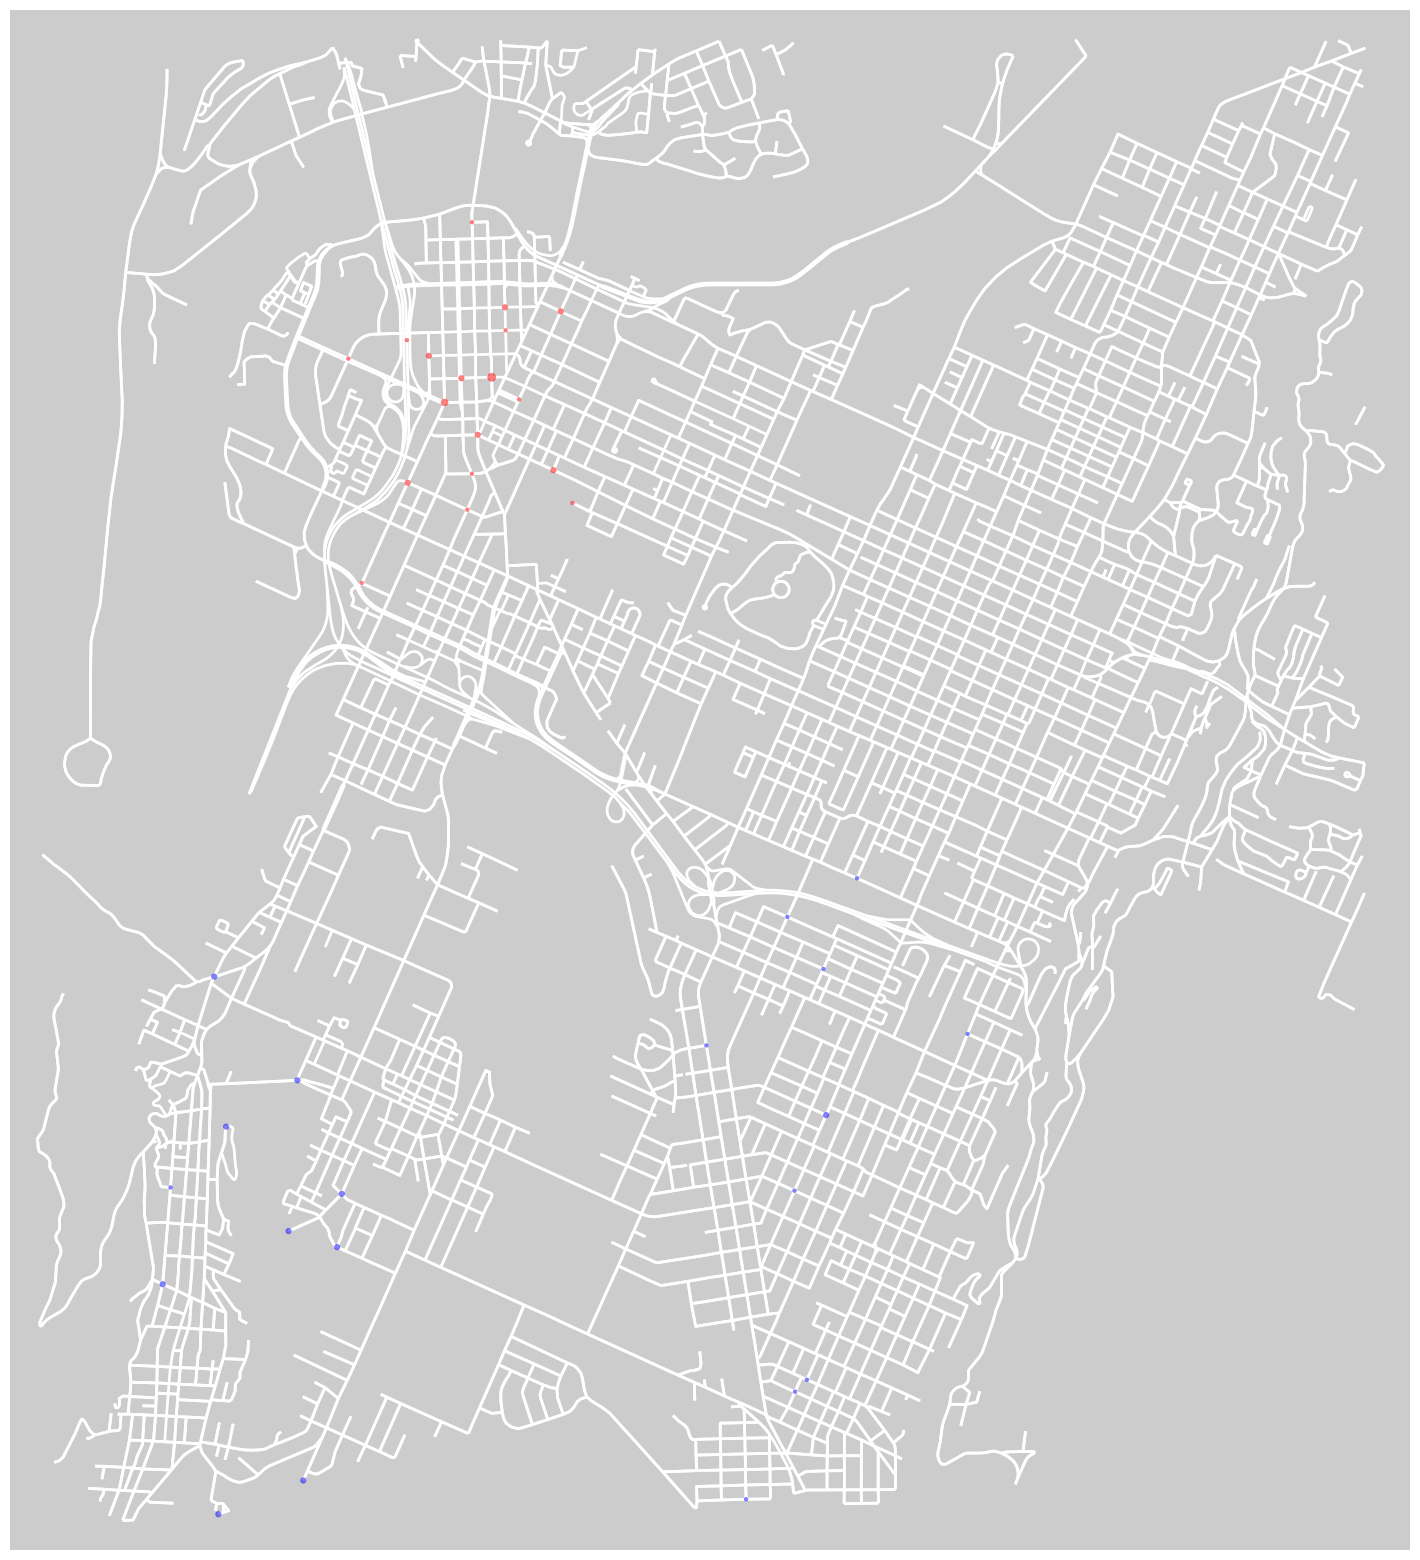

In [14]:
plotODs(GRAPHS,SIZES,NODES,scale=1.)

In [ ]:
## WORK WITH PAY

In [ ]:
file = open('data/webapp/localDB_payload.pkl', 'rb'); PAY = pickle.load(file); file.close()
file = open('data/webapp/localDB_data_manifest.pkl', 'rb'); MAN = pickle.load(file); file.close()

In [ ]:
zz = MAN
print(len(zz))
for i,z in enumerate(zz):
    print(z)

In [ ]:
zz = PAY['requests']
for i,z in enumerate(zz):
    print('')
    print('REQUEST: ',i)
    print('pickup pt: ',z['pickup_pt']);
    print('dropoff pt: ',z['dropoff_pt']);
    print('booking id: ', z['booking_id']);

    

    print('pickup node: ',z['pickup_node_id']);
    print('drop off node: ',z['dropoff_node_id']);
print(PAY['depot'])
print(PAY['date'])

In [ ]:
TIME_MATRIX = PAY['time_matrix']
print(np.array(TIME_MATRIX).shape)

In [ ]:
PDF = payloadDF(PAY,GRAPHS)

In [ ]:
MDF = manifestDF(MAN,PDF);

In [ ]:
MDF.head()

In [ ]:
ZZ = MDF[MDF['run_id']==1]
zz = list(ZZ.sort_values(['scheduled_time'])['drive_node'])

In [ ]:
PATH = routeFromStops(zz,GRAPHS['drive'])
PLANS = routesFromManifest(MDF,GRAPHS)


In [ ]:
print(len(PATH['edges']))
print(len(PATH['nodes']))

In [ ]:
booking_ids = list(PDF['booking_id'])
ids_to_keep = sample(booking_ids,10)
print(ids_to_keep)

In [ ]:
PAY2 = filterPayloads(PAY,ids_to_keep)

In [ ]:
print(PAY2)

In [ ]:
print(PAY.keys())

In [ ]:
# print(PAY['date'])
# print(PAY['depot']) #.keys())

# zz = PAY['driver_runs'] #.keys())
# for i,z in enumerate(zz): print(z)

zz = PAY['requests'] #.keys())
for i,z in enumerate(zz):
    print(z.keys())
    asdfasdfasd

#print(np.shape(np.array(PAY['time_matrix'])))

# for i,z in enumerate(zz):
#     print(z)


In [ ]:

def getBookingIds(PAY):
    booking_ids = [];
    for i,request in enumerate(PAY['requests']):
        booking_ids.append(request['booking_id'])
    return booking_ids

def filterPayloads(PAY,ids_to_keep):
    OUT = {};
    OUT['date'] = PAY['date']
    OUT['depot'] = PAY['depot']
    OUT['driver_runs'] = PAY['driver_runs']
    OUT['time_matrix'] = PAY['time_matrix']

    OUT['requests'] = [];
    for i,request in enumerate(PAY['requests']):
        if request['booking_id'] in ids_to_keep: 
            OUT['requests'] = request
    return OUT;
    

In [ ]:
%load_ext autoreload
%autoreload 2
from multimodal_functions import * 
#         node_color.append(cmap(Mlocs[ii]/maxMloc))
show_nodes = {}
show_nodes['pickup'] = list(PYY['pickup_drive_node'])
show_nodes['dropoff'] = list(PYY['dropoff_drive_node'])

# print(PATH['edges'])
node_colors = [[0,0,1,1],[1,0,0,1]]
cmap = plt.get_cmap('viridis') 
temp = 8; edge_colors = []
for i in range(temp):
    edge_colors.append(list(cmap(i/temp)))
    
node_lists = [list(PYY['pickup_drive_node']), list(PYY['dropoff_drive_node'])]
edge_lists = [PLANS[plan]['edges'] for _,plan in enumerate(PLANS)]
dat = {'node_lists':node_lists,'edge_lists':edge_lists,'node_colors':node_colors,'edge_colors':edge_colors,
      'edge_widths':4*np.ones(len(edge_lists))}
plotGRAPH(GRAPHS['drive'],dat)
# plotPAYLOAD(GRAPHS,show_nodes,PATH['edges'],scale = 100)

In [ ]:

# def routesFromManifest(MDF,GRAPHS):
#     max_id_num = int(np.max(list(MDF['run_id'])))
#     PLANS = {};
#     for i in range(max_id_num):
#         ZZ = MDF[MDF['run_id']==i]
#         ZZ = list(ZZ.sort_values(['scheduled_time'])['drive_node'])
#         out = routeFromStops(ZZ,GRAPHS['drive']);
#         PLANS[i] = out.copy();
#     return PLANS

# def routeFromStops(nodes,GRAPH):
#     PATH_NODES = [];
#     for i,node in enumerate(nodes):
#         if i<len(nodes)-1:
#             start_node = node; end_node = nodes[i+1]
#             path = nx.shortest_path(GRAPH, source=start_node, target=end_node,weight = 'c'); #, weight=None);
#             PATH_NODES = PATH_NODES + path

#     PATH_EDGES = [];
#     for i,node in enumerate(PATH_NODES):
#         if i<len(PATH_NODES)-1:
#             start_node = node; end_node = PATH_NODES[i+1]
#             PATH_EDGES.append((start_node,end_node))
#     return {'nodes':PATH_NODES,'edges':PATH_EDGES}



In [ ]:
# print(PLANS)

# SETUP NODES DATAFRAME (takes 10 min...)

In [15]:
from multimodal_functions import * 

# ndfs_to_rerun = ['gtfs','transit','delivery1','delivery2','source','target'];
ndfs_to_rerun = ['delivery1','delivery2','source','target'];
NDF = SETUP_NODESDF_CHATTANOOGA(GRAPHS,NODES,NDF=NDF,ndfs_to_rerun=ndfs_to_rerun)
#BUS_STOP_NODES = INITIALIZING_BUSSTOPCONVERSION_CHATTANOOGA(GRAPHS);
BUS_STOP_NODES = {};

time to create nodes...:  1.1920928955078125e-06
starting delivery1 sources...
0
starting delivery2 sources...
0
starting source nodes...
0
starting target nodes...
0
time to create nodes...:  5.674314260482788


# WORLD

In [108]:
%load_ext autoreload
%autoreload 2

from multimodal_functions import * 

graph = GRAPHS['drive']
nodes = list(graph.nodes())

factors = ['time','money','conven','switches'];
people_tags = list(PRE)
num_people = len(people_tags);
num_people = len(LOCS['orig']);          # 
modes = ['drive','ondemand','walk','transit','gtfs'];
graphs = ['drive','ondemand','walk','transit','gtfs'];
    
params = {}
params['modes'] = modes; params['graphs'] = graphs; params['nodes'] = nodes;
params['people_tags'] = people_tags; params['factors'] = factors;

WORLD = generateWorld(GRAPHS,params)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## DELIVERY 

In [109]:
%load_ext autoreload
%autoreload 2

from multimodal_functions import * 

params = {}
params['direct_locs'] = LOCS['delivery1']; params['shuttle_locs'] = LOCS['delivery2'];
params['NODES'] = NODES;
# params['BUS_STOP_NODES'] = BUS_STOP_NODES;

DELIVERY = generateDeliveries(GRAPHS,NDF,params);   
DELIVERY2 = DELIVERY['shuttle']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
updateNodesDF(NDF);

#### PEOPLE, DELIVERY - INITIALIZATION (takes 20 MIN...(40 people/min))

In [111]:
%load_ext autoreload
%autoreload 2

from multimodal_functions import * 

modes = ['drive','transit','ondemand','walk','gtfs']
params = {}
params['modes'] = modes; params['graphs'] = graphs;
params['nodes'] = nodes; params['factors'] = factors; params['mass_scale'] = 4./3600.
asdf = generatePopulation(GRAPHS,DELIVERY,WORLD,NDF,VEHS,LOCS,PRE,params,verbose = True);

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
GENERATING POPULATION OF 30 ...
person0
time to add 10 people:  4.696846008300781e-05
person10
time to add 10 people:  14.18997597694397
person20
time to add 10 people:  13.462796926498413


In [112]:
PEOPLE = asdf;

In [113]:
updateNodesDF(NDF);

In [103]:
#PRE['person0']
print(num_people)

30


# ----------------- PRELOADED DATA START ---------------------------
# ----------------- PRELOADED DATA START ---------------------------


# LOAD DATA (default: False)

In [ ]:
reload_data = True;
#filename = 'data/data1176.obj'
# filename = 'data/data1073.obj'
# filename = 'data/data353.obj'
# filename = 'data/data103.obj'
# filename = 'data/small_data287.obj'
# filename = 'data/small_data228_select.obj'
# filename = 'runs/small_data233_select.obj'
# filename = 'runs/small_data306_blank.obj'
filename = 'runs/small_data233_select.obj'

# import pandas as pd

# df = pd.read_pickle("file.pkl")

if reload_data:
    #feed = pt.get_representative_feed('carta_gtfs.zip') #loading gtfs from chattanooga
    feed = gtfs.Feed('carta_gtfs.zip', time_windows=[0, 6, 10, 12, 16, 19, 24])
    file = open(filename, 'rb')
    DATA = pickle.load(file)
    DATA = pd.read_pickle(filename)
    file.close()
    
reread_data = True;
if reread_data:
    asdf = DATA['PEOPLE']
    WORLD = DATA['WORLD']
    DELIVERY = DATA['DELIVERY']
    NDF = DATA['NDF']
    #GRAPHS = DATA['GRAPHS']
    PRE = DATA['PRE'];
    BUS_STOP_NODES = DATA['BUS_STOP_NODES']
    NODES = DATA['NODES']
    LOCS = DATA['LOCS']    
    SIZES = DATA['SIZES']
GRAPHS['gtfs'] = feed;

# for i,tag in enumerate(PEOPLE):
#     # PEOPLE[tag]['mass_total'] = PEOPLE[tag]['mass']
#     # PEOPLE[tag]['mass'] = 4*PEOPLE[tag]['mass_total']/(3600);
#     print(PEOPLE[tag]['mass'])

### ... ASSIGN PEOPLE (default: False)

In [ ]:
assign_people = True;
if assign_people: 
    PEOPLE = asdf;

# LOAD GTFS (default: True)

In [22]:
import pickle
import os.path

reload_gtfs = True;
filename = 'data/gtfs/gtfs_trips.obj'
if reload_gtfs:
    file = open(filename, 'rb')
    data = pickle.load(file)
    file.close()

    REACHED_NODES = data['REACHED_NODES']
    PREV_NODES = data['PREV_NODES']
    PREV_TRIPS = data['PREV_TRIPS']



### ... ASSIGN GTFS (default: True)

In [23]:
assign_gtfs = False;
WORLD['gtfs']['precompute'] = {};
WORLD['gtfs']['precompute']['reached'] = REACHED_NODES;
WORLD['gtfs']['precompute']['prev_nodes'] = PREV_NODES;
WORLD['gtfs']['precompute']['prev_trips'] = PREV_TRIPS;


In [24]:
print(WORLD.keys())

dict_keys(['main', 'drive', 'ondemand', 'walk', 'transit', 'gtfs'])


# SAVE DATA (default: False)

In [25]:
# #### DON"T CHANGE 
rewrite_data = True; 
num_people = len(list(PEOPLE))
filename = 'runs/small_data'+str(num_people)+'_blank.obj'
# filename = 'current.obj'
# if os.path.isfile(filename):
#     filename
# import pickle
# import os.path
# filename = 'gtfs_trips.obj'
# if os.path.isfile(filename):

if rewrite_data:
    fileObj = open(filename, 'wb')
    GRAPHSnoGTFS = {}
    for j,mode in enumerate(GRAPHS):
        if not(mode == 'gtfs'):
            GRAPHSnoGTFS[mode] = GRAPHS[mode]
            
    DATA = {
            'PEOPLE':PEOPLE,
            'WORLD':WORLD,
            'DELIVERY':DELIVERY,
            'NDF':NDF,
            'NODES':NODES,
            'LOCS':LOCS,
            'PRE':PRE,        
            'BUS_STOP_NODES':BUS_STOP_NODES,
            # 'GRAPHS':GRAPHSnoGTFS,
            'SIZES':SIZES
           }
#             'GRAPHS':GRAPHS}
    pickle.dump(DATA,fileObj)
    fileObj.close()


# -------------- MAIN SIMULATION ------------------
# -------------- MAIN SIMULATION ------------------

In [114]:
# DELIVERY['date'] = '2023-07-31'
# DELIVERY['depot'] = {'pt': {'lat': center_point[1], 'lon': center_point[0]}, 'node_id': 0}


# print(WORLD.keys())
# : estimate for travel times 
# GRAPHS:  
# PEOPLE: estimate 

In [115]:
add_base_edge_masses(GRAPHS,WORLD,WORLD0);

In [141]:
%load_ext autoreload
%autoreload 2

from multimodal_functions import * 

WORLD['main']['iter'] = 0.;
WORLD['main']['alpha'] = 1./(WORLD['main']['iter']+1.);

nk = 2; 

# GRADIENT DESCENT...
for k in range(nk):
    start_time = time.time();
    print('------------------ITERATION',int(WORLD['main']['iter']),'-----------')
    # alpha =1/(k+10.);

    world_of_gtfs(WORLD,PEOPLE,GRAPHS,NDF,verbose=True);    
    world_of_drive(WORLD,PEOPLE,GRAPHS,verbose=True); #graph,costs,sources, targets):    
    world_of_ondemand(WORLD,PEOPLE,DELIVERY,GRAPHS,verbose=True,show_delivs='all');
    world_of_walk(WORLD,PEOPLE,GRAPHS,verbose=True); #graph,costs,sources, targets):    
    #world_of_transit_graph(WORLD,PEOPLE,GRAPHS,verbose=True);
    

    print('updating individual choices...')
    update_choices(PEOPLE, DELIVERY, NDF, GRAPHS,WORLD,takeall=False);
    end_time = time.time()
    
    print('iteration time: ',end_time-start_time)
    WORLD['main']['iter'] = WORLD['main']['iter'] + 1.;
    WORLD['main']['alpha'] = 1./(WORLD['main']['iter']+1.);


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
------------------ITERATION 0 -----------
starting gtfs computations...
...with  110  active trips...
REMOVING MASS FROM GTFS TRIPS...
starting driving computations...
...with  0  active trips...
starting on-demand computations...
...with 150 active ondemand trips...
starting walking computations...
...with  120  active trips...
>>> segment 0 ...
updating individual choices...
person0 ...
iteration time:  1.4714090824127197
------------------ITERATION 1 -----------
starting gtfs computations...
...with  0  active trips...
REMOVING MASS FROM GTFS TRIPS...
starting driving computations...
...with  0  active trips...
starting on-demand computations...
...with 30 active ondemand trips...
starting walking computations...
...with  0  active trips...
updating individual choices...
person0 ...
iteration time:  1.1464319229125977


# ---------- GRAPHING --------------

In [ ]:
# print(WORLD['ondemand']['active_trips_shuttle'][:10])
# print(WORLD['ondemand']['active_trips_direct'][:10])

trip1 = WORLD['ondemand']['active_trips_shuttle'][0]
trip2 = WORLD['ondemand']['active_trips_direct'][0]

print(WORLD['ondemand']['trips'][trip1])

In [137]:

WORLD['main']['iter'] = 0.;
WORLD['main']['alpha'] = 1./(WORLD['main']['iter']+1.);
WORLD['main']['start_time'] = 0;
WORLD['main']['end_time'] = 14400;

In [ ]:
%load_ext autoreload
%autoreload 2
from multimodal_functions import *

import warnings
warnings.filterwarnings('ignore')

fileName = 'current.pdf'

shows = {'drive': True,
         'walk':False,
         'transit':False,
         'ondemand':True,
         'direct':True,
         'shuttle':True,
         'ondemand_indiv':False,
         'lines':True,
         'gtfs':True,
         'source':True,
         'target':True,
         'legend':True,
         'base':True}
maxwids = {'drive': 10.,'walk':6,'transit':10,'lines':4,'gtfs':10,'ondemand':2,'direct':1,
            'ondemand_indiv':10,'base':4.}

colors = {'shuttle':[1,0.5,0.5]}

# mxpop1 = 1.
mxpops = {'drive': 1.,'walk':1,'transit':1,'lines':1,'gtfs':0.01,'ondemand':1}

params = generate_graph_presets(fileName,shows,WORLD,maxwids,mxpops,other_edges = True)
params['SIZES'] = SIZES;
params['colors']['shuttle'] = [0.,0.,1.]
params['set_alphas'] = {'direct':0.6,'shuttle':0.6}
params['set_wids'] = {'direct':4,'shuttle':4}
                         
start_time = time.time()
cmap = plt.get_cmap('autumn')
plot_multimode(GRAPHS,NODES,DELIVERY,WORLD,params);


# TEST SECTION

In [ ]:
show_edges = False;
show_trips = True;

edgeMasses = {};
edgeCosts = {};
tripCosts = {};
tripMasses = {};
modes = ['drive','gtfs','walk','ondemand']

if show_edges:
    fig1,axs = plt.subplots(3,4,figsize=(12,6));
    fig1.tight_layout(pad=2.0)
    typtoshow = 'current_edge_masses'
    rowind = 0; 
    for m,mode in enumerate(modes):
        edgeMasses[mode] = [];
        for e,edge in enumerate(WORLD[mode][typtoshow]):
            edgeMasses[mode].append(WORLD[mode][typtoshow][edge])
        axs[rowind][m].set_title(mode+': '+typtoshow[8:]);
        axs[rowind][m].plot(edgeMasses[mode])
    
    typtoshow = 'current_edge_costs'
    rowind = 1; rowind2 = 2;
    for m,mode in enumerate(modes):
        edgeCosts[mode] = [];
        for e,edge in enumerate(WORLD[mode][typtoshow]):
            costs = WORLD[mode]['edge_costs'][edge]
            edgeCosts[mode].append(WORLD[mode][typtoshow][edge])
            if np.abs(costs[0]-costs[-1]) > 0.01:
                axs[rowind2][m].plot(costs)
    
        axs[rowind][m].set_title(mode+': '+typtoshow[8:]);
        axs[rowind][m].plot(edgeCosts[mode])


########################################################################################
########################################################################################
print('')
print('')
print('')

toshows = ['drive','walk','gtfs','shuttle','direct']
rowinds = [0,1,2];
if show_trips:
    fig2,axs = plt.subplots(3,len(toshows),figsize=(12,6));
    fig2.tight_layout(pad=2.0)
    
    typtoshow = 'trips'
    # rowind = 0;
    # for m,mode in enumerate(modes):
        
    #     for tt,trip in enumerate(WORLD[mode]['active_trips']):
    #         cost = WORLD[mode]['trips'][trip]['mass']
    #         tripMasses[mode].append(cost)
    
    
    typtoshow = 'trips'
    rowind = 1; rowind2 = 2;
    for m,toshow in enumerate(toshows):
        tripMasses[toshow] = [];
        tripCosts[toshow] = [];
        if toshow == 'shuttle':
            mode = 'ondemand';
            active_trips = WORLD[mode]['active_trips_shuttle'];
        elif toshow == 'direct':
            mode = 'ondemand';
            active_trips = WORLD[mode]['active_trips_direct'];
        else:
            mode = toshow;
            active_trips = WORLD[mode]['active_trips'];

        for tt,trip in enumerate(active_trips):

            tripMasses[toshow].append(WORLD[mode]['trips'][trip]['mass'])
            
            costs = WORLD[mode]['trips'][trip]['costs']['time']
            # if True: #len(costs)<nk:
            # print(costs[-1])
            if len(costs)>0:
                if costs[-1]<1000000000:
                    tripCosts[toshow].append(costs[-1])
                    if True: #np.abs(costs[0]-costs[-1]) > 0.01:
                        axs[rowinds[2]][m].plot(costs)

        axs[rowinds[0]][m].set_title(toshow+': '+'trip masses');
        axs[rowinds[0]][m].plot(tripMasses[toshow])
        
        axs[rowinds[1]][m].set_title(toshow+': '+'trip costs');
        axs[rowinds[1]][m].plot(tripCosts[toshow])

        axs[rowinds[2]][m].set_title(toshow+': '+'convergence');


    
        


#  END OF WORKING #  END OF WORKING #  END OF WORKING # 
#  END OF WORKING #  END OF WORKING #  END OF WORKING # 
#  END OF WORKING #  END OF WORKING #  END OF WORKING # 

# SAVE POPULATION DATA?

In [ ]:

save_pop_data = False;
home_locs = NODES['orig'];
work_locs = NODES['dest'];
if save_pop_data:
    ASDF = {}
    ASDF['home_locs'] = home_locs;
    ASDF['work_locs'] = work_locs;
    ASDF['home_sizes'] = home_sizes;
    ASDF['work_sizes'] = work_sizes;
    ASDF['home_nodes'] = home_nodes;
    ASDF['work_nodes'] = work_nodes;

    fileObj = open('data/ods10k.obj', 'wb')
    pickle.dump(ASDF,fileObj)
    fileObj.close()

# RECOMPUTE GTFS FEED (takes 2 hrs...)

In [ ]:
recompute = False;
if recompute: 
    asdf = calculateGTFStrips(feed); # SOLVED = 
    fileObj = open('data/gtfs/gtfs_trips2.obj', 'wb')
    pickle.dump(SOLVED,fileObj)
    fileObj.close()

# START NEW ---------- 
# TYPE CODE - GRAPH PLOTS

## ----------------- END SANDBOX --------------------END SANDBOX --------------------